# Model Evaluation

## What is Model Evaluation?

Model evaluation is an umbrella term and there are a lot of concepts that make it up.

It is the process of quantifying the generalization of the models we design and create. This part of the machine learning workflow can be the most frustrating, but you can gain a lot of insights from the iterative nature of model evaluation. As data scientists / analysts / enthusiasts, we might dive straight into designing / training the most complicated models but we should begin a machine learning project, like other business projects, by defining our metrics of success.

In this bootcamp, I will cover a few key concepts to let you get started.

If you already have experience in the machine learning workflow, you will see a lot of overlap between what you already know and what I will be speaking about.

## Why is it Important?

Without model evaluation, we would not be able to conclusively say whether or not our models are good representations of our problem space (i.e. we cannot say our model has found the function that best describes the target variable from input variables).

Multiple models of the same kind (e.g. linear regression, svm, neural network) evaluated with different methods can produce wildly different conclusions that may make or break your project. In some cases, some kinds of models aren't feasible without sinking large capital into collecting data.

### Important Reminder

- Always set the seed to a static value when you're evaluating and comparing models / results!

In [1]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import pandas as pd
import numpy as np
from numpy.random import rand, randn

__SEED__ = 42

np.random.seed(__SEED__)


Let's start with a relatively simple function that everyone knows:

In [2]:
def cos_wave(input: list) -> list:
    return np.cos(input * 2 * np.pi)


Quickly visualize this function:

In [3]:
import plotly.graph_objects as go

N = 200
d = 3
t = np.linspace(0, d * N, N)
fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=cos_wave(t), mode="lines", name="cos"))
fig.show()


Great! That looks pretty simple, doesn't it?

Here, we're going to do a quick modeling exercise to drive the point home.

Generate a random number of points and model the function using one of scikit-learn's models.

In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import plotly.graph_objects as go

N = 50
t = np.linspace(0, 1, N)
X = np.sort(rand(N))

noise = 0.2
y = cos_wave(X) + randn(N) * noise

fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=cos_wave(t), mode="lines", name="cos()"))
fig.add_trace(go.Scatter(x=X, y=y, mode="markers", name="cos() + noise"))
fig.show()

model = make_pipeline(PolynomialFeatures(degree=80), LinearRegression())
model.fit(X[:, np.newaxis], y)

fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=y, mode="markers", name="cos() + noise"))
fig.add_trace(go.Scatter(x=t, y=cos_wave(t), name="cos()"))
fig.add_trace(go.Scatter(x=t, y=model.predict(t[:, np.newaxis]), name="model"))
fig.update_yaxes(range=[-2, 2])
fig.update_layout(title=f"model (score: {np.round(model.score(X[:, np.newaxis], y), 8)})")
fig.show()


As you can see from the 2nd plot, this is a terrible model. It has not learned the underlying function because the model is overfitting. It's not modeling only the underlying function but it's also modeling the noise in the dataset.

In real-world examples, we don't have the luxury of knowing the underlying function and so you truly have to become a detective and dive into your models to evaluate what it is doing. If we took this model and used it to predict values without evaluating it or knowing the underlying function, we might think it's doing extremely well.

# Train & Test Splits

There are quite a few methods to try to combat overfitting and some are niche to a specific type of problem.

With all machine learning workflows, we should always take steps to allow us to identify and diagnose our models. The 2 most common concepts are:

- Train / test split
- Cross validation

## Train / Test Split

Splitting data into train and test sets allows us to determine if the model will perform well on data it has never seen before (i.e. how well does the model generalize the underlying function?). It does not prevent issues, it only allows us to determine if there are issues with our model.

- 20% - 35% split is most common (e.g. 20% test set, 80% train set)
  - Larger test set means less data to train on and vice versa
- Sets should be statistically identical / close to identical
  - E.g. check the mean, median, distribution are similar

Used in the previous bootcamps, it is simple to do this in scikit-learn:

In [5]:
from sklearn.model_selection import train_test_split

x_train_cos, x_test_cos, y_train_cos, y_test_cos = train_test_split(
    X, y, test_size=0.3, random_state=__SEED__
)

fig = go.Figure()
fig.add_trace(go.Scatter())
fig.add_trace(go.Scatter(x=x_train_cos, y=y_train_cos, mode="markers", name="train_set"))
fig.add_trace(go.Scatter(x=x_test_cos, y=y_test_cos, mode="markers", name="test_set"))


We've successfully split the data into train and test sets.

There's a problem with this and it goes back to the second bullet point from above:

- `Sets should be statistically identical / close to identical`

What happens if our dataset is split in a way that introduces a bias into our model? For example:

- All or most of a single class is in one of the sets only.
- "Low" values are in one set and the "high" values are in the other.

Imagine the different possibilities that'll introduce a bias from the split. There might be a lot and that's not something we want.

# Cross Validation

To counter this, we perform "cross-validation". There are a few different cross-validation types out there:

- Leave-One-Out / KFold
  - Leave-One-Out is equivalent to KFold when the number of splits is equal to the number of samples
- GroupKFold
- GroupShuffleSplit
- LeaveOneGroupOut
- LeavePGroupsOut
- LeavePOut
- PredefinedSplit
- RepeatedKFold
- RepeatedStratifiedKFold
- ShuffleSplit
- StratifiedKFold
- StratifiedShuffleSplit
- TimeSeriesSplit

This list is from scikit-learn's [documentation](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) under `Splitter Classes`.

Starting with the most simple one: **KFold / Leave-One-Out Cross Validation**

![title](../assets/example_leave_one_out_cv.png)

In scikit-learn, you can create KFold cross-validator by:

In [6]:
from sklearn.model_selection import KFold

kf = KFold(
    n_splits=5
)  # setting to N (number of samples) is the same as a Leave-One-Out cv

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print("=" * 20)
    print(f"X: {X_test}\ny: {y_test}")


X: [0.02058449 0.03438852 0.04645041 0.05808361 0.06505159 0.09767211
 0.12203823 0.13949386 0.15599452 0.15601864]
y: [1.13934104 1.01102133 0.93458168 0.87392083 0.62192144 0.67355857
 0.62801461 0.85129557 0.62562787 0.2041703 ]
X: [0.17052412 0.18182497 0.18340451 0.18485446 0.19967378 0.21233911
 0.25877998 0.29122914 0.29214465 0.30424224]
y: [ 0.54368204  0.33835978  0.27094365  0.52032225  0.51716562  0.42068423
 -0.22298178 -0.31800516 -0.1954661  -0.13914542]
X: [0.30461377 0.31171108 0.36636184 0.37454012 0.43194502 0.44015249
 0.45606998 0.49517691 0.51423444 0.52006802]
y: [-0.43228848 -0.41523092 -0.88897306 -0.94430196 -0.7474576  -0.65888077
 -0.97654963 -0.79883428 -0.92367592 -1.121085  ]
X: [0.52475643 0.54671028 0.59241457 0.59865848 0.60111501 0.60754485
 0.61185289 0.66252228 0.68423303 0.70807258]
y: [-0.91564747 -0.64963295 -0.84326715 -0.5010139  -1.32882827 -0.61587367
 -0.74563084 -0.58218065 -0.3832138  -0.65791503]
X: [0.73199394 0.78517596 0.80839735 0.832

That's it! It's that easy to incorporate cross-validation into your workflow.

However, there is a small caveat with this though! Let me show how KFold is operating:

In [7]:
for train_index, test_index in kf.split(X):
    print(f"Train: {train_index}\nTest: {test_index}")

Train: [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
Test: [0 1 2 3 4 5 6 7 8 9]
Train: [ 0  1  2  3  4  5  6  7  8  9 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
Test: [10 11 12 13 14 15 16 17 18 19]
Train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
Test: [20 21 22 23 24 25 26 27 28 29]
Train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 40 41 42 43 44 45 46 47 48 49]
Test: [30 31 32 33 34 35 36 37 38 39]
Train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Test: [40 41 42 43 44 45 46 47 48 49]


From that, you can see that KFold is actually taking things in sequential groups. Now, that isn't a huge issue, but usually the data we read is sorted in some fashion. The sorting prevents our KFolds from randomness.

For example, in the sense of a well log where you wanted to classify formations based on independent row data (order of rows do not matter, time-series is an example where order does matter), depths are a natural split so it needs to be taken care of.

In this case, we will need to shuffle by doing the following:

In [8]:
kf = KFold(
    n_splits=5,
    shuffle=True,
    random_state=__SEED__
)

for train_index, test_index in kf.split(X):
    print(f"Train: {train_index}\nTest: {test_index}")
    break  # show only 1 to be succinct

Train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 18 20 21 22 23 24 27 28
 29 31 33 34 35 36 37 38 40 41 42 43 44 46 47 49]
Test: [13 17 19 25 26 30 32 39 45 48]


If the data is unbalanced (classification task) even after the shuffle, you can use `StratifiedKFold` and it works like this:

![title](../assets/example_stratified_kfold.png)

To do StratifiedKFold in scikit-learn:

In [9]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=__SEED__)


# Dummy Models

This is similar to Scott's use of a baseline model.

Dummy models take a naive approach to this and they take some constant statistical measure (or user-supplied value) as their predictions.

The idea is that your model should be able to beat the performance of these dummies. If it can't, your model has failed to outperform a naive model and should be reassessed.

Source:
- DummyClassifier [https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn.dummy.DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn.dummy.DummyClassifier)
- DummyRegressor [https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html#sklearn.dummy.DummyRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html#sklearn.dummy.DummyRegressor)


In [10]:
from sklearn.dummy import DummyRegressor, DummyClassifier

X = np.array([1.0, 2.0, 3.0, 4.0])
y = np.array([2.0, 3.0, 5.0, 10.0])
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X, y)
dummy_regr.predict(X)
print(dummy_regr.score(X, y))

X = np.array([-1, 1, 1, 1])
y = np.array([0, 1, 1, 1])
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)
dummy_clf.predict(X)
print(dummy_clf.score(X, y))


0.0
0.75


# Metrics

As Scott said, metrics can change the outcome of your model.

Metrics can be divided into two buckets:

- Classification metrics
- Regression metrics

It is **important** to understand that there is no "best" metric to use for everything. It depends on your data (input & output) and the business requirements you need to meet.

## Classification Metrics

### Accuracy

The simplest classification metric is `Accuracy`. Accuracy is the percentage of predictions our model got right.

${Accuracy} = \frac{{TP} + {TN}}{{TP} + {FP} + {TN} + {FN}} $

Or predictions model got right / total predictions

Accuracy is heavily skewed towards the majority class. For example, in financial fraud detection, fraud may occur only 0.1% of all transactions and the model may always just choose "not fraud" and accuracy will still be extremely high. In this case, accuracy would be the wrong metric to use.

N.B. [https://en.wikipedia.org/wiki/Accuracy_paradox](https://en.wikipedia.org/wiki/Accuracy_paradox)

In [11]:
from sklearn.metrics import accuracy_score

# do not run
# accuracy_score = accuracy_score(y_test, predictions)


### Precision

Precision is "When it predicts yes, how often is it correct?"

This can be understood as a level of confidence for the model. If the model predicts "true" and it's false, it would be penalized heavily by this metric. In other words, a model would be trained to be risk-averse when using this metric.

In [12]:
from sklearn.metrics import precision_score

# do not run
# precision_score = precision_score(y_test, predictions)


### Sensitivity / Recall / True Positive Rate

Sensitivity is "When it's actually yes, how often does it predict yes?"

This can be viewed as the inverse of precision. It rewards the model for guessing "true". If it guessed false and it was actually true, this metric would penalize the model. In this case, the model would train to assign "true" with a low confidence threshold.

In [13]:
from sklearn.metrics import recall_score

# do not run
# recall_score = recall_score(y_test, predictions)


### Confusion Matrix

A handy tool to calculate the different statistical measures for classification models:

![title](../assets/example_confusion_matrix.jpg)

Source: [MartinThoma](https://commons.wikimedia.org/wiki/File:Roc-draft-xkcd-style.svg)

### F1 Score

Now that we know there is a relationship between Precision and Sensitivity, you might want to know how we can tune a model to an optimal split between the two metrics.

To do this, we use the F1 score. It is the harmonic mean between Precision and Sensitivity.

This can be viewed as "How many correct classifications the model predicted?" and "How many times it did not miss a classification?" with respect to Type 1 Error and Type 2 Errors.

TLDR:
- F1 finds the balance between precision and sensitivity.
- Higher F1 score means the model is better
- Bound: [0, 1]

### ROC and AUC

Particularly when we have imbalanced classes, we use what's called ROC or Receiver Operating Characteristic curve. It is created by varying the classification threshold and plotting the fraction of true positives out of all positive cases (true positive rate, or TPR) vs. false positives out of all negative cases (false positive rate, or FPR) at each threshold value.

Since the ROC curve is a qualitative measure, we cannot use it to compare models easily. This is where AUC comes into play. AUC is the **A**rea **U**nder **C**urve of the ROC curve. It allows us to quantitatively compare different classification models.

In practice, a higher AUC for a given sensitivity will be more accurate than a lower AUC. In other words, AUC of 1.0 has all predictions made correctly and AUC of 0.5 is a model that is as good as a classifier that chooses randomly (gaussian distribution).

This will vary for every case but this can be treated as a rough guideline:

1. 1.0 - 0.9 -> Amazing model
2. 0.9 - 0.8 -> Good
3. 0.8 - 0.7 -> Ok
4. 0.7 - 0.6 -> Poor
5. 0.6 - 0.5 -> Failed model

![title](../assets/example_roc.svg)

Source: [https://manisha-sirsat.blogspot.com/2019/04/confusion-matrix.html](https://manisha-sirsat.blogspot.com/2019/04/confusion-matrix.html)


It is important to tune your precision / sensitivity & classification threshold because it defines what your model is willing to risk and what it is not. In some uses, this can be life changing for someone (e.g. accused of fraud, medical diagnosis, etc.).

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score

# do not run
# fpr, tpr, thresholds = roc_curve(y_test, predictions)
# roc_auc_score(y_test, predictions)


Score (train) for L1 logistic: 83.3% 
Score (train) for L2 logistic (Multinomial): 82.7% 
Score (train) for L2 logistic (OvR): 79.3% 
Score (train) for Linear SVC: 82.0% 
Score (train) for GPC: 82.7% 
----------------------------------------------------------------------------------------------------


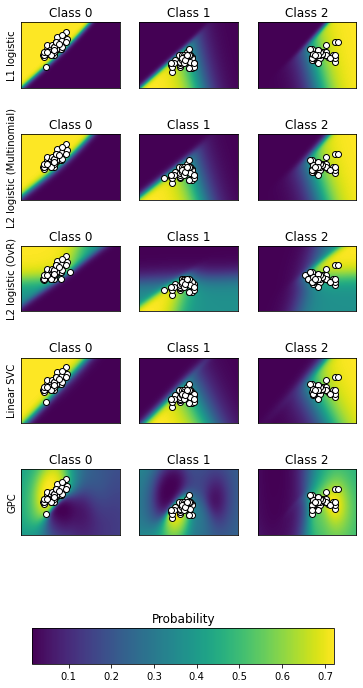

Score (train) for L1 logistic: 83.3% 
Score (train) for L2 logistic (Multinomial): 82.7% 
Score (train) for L2 logistic (OvR): 79.3% 
Score (train) for Linear SVC: 82.0% 
Score (train) for GPC: 82.7% 
----------------------------------------------------------------------------------------------------


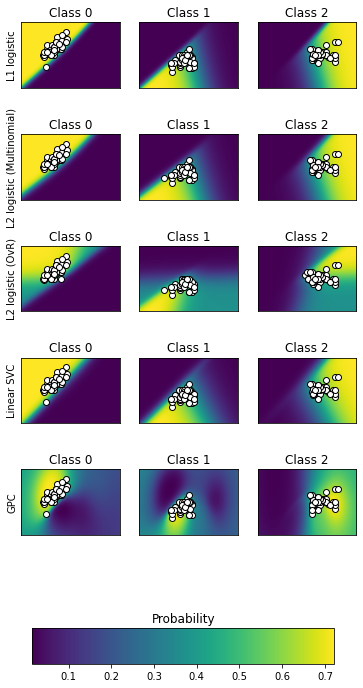

Score (train) for L1 logistic: 83.3% 
Score (train) for L2 logistic (Multinomial): 82.9% 
Score (train) for L2 logistic (OvR): 79.3% 
Score (train) for Linear SVC: 82.1% 
Score (train) for GPC: 82.7% 
----------------------------------------------------------------------------------------------------


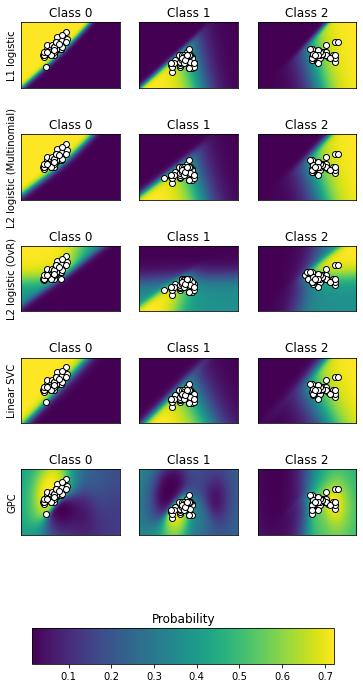

Score (train) for L1 logistic: 82.7% 
Score (train) for L2 logistic (Multinomial): 82.7% 
Score (train) for L2 logistic (OvR): 79.3% 
Score (train) for Linear SVC: 82.0% 
Score (train) for GPC: 82.7% 
----------------------------------------------------------------------------------------------------


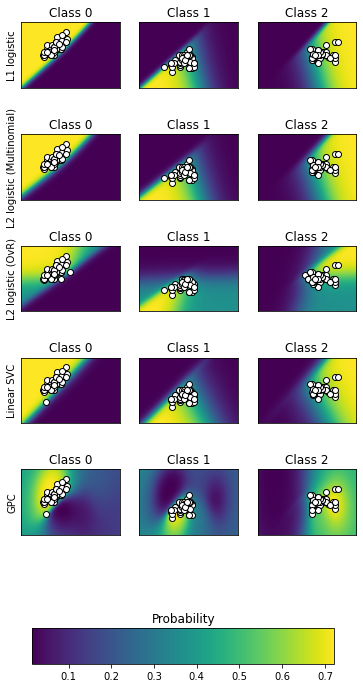

Score (train) for L1 logistic: 82.7% 
Score (train) for L2 logistic (Multinomial): 82.7% 
Score (train) for L2 logistic (OvR): 79.2% 
Score (train) for Linear SVC: 82.0% 
Score (train) for GPC: 82.7% 
----------------------------------------------------------------------------------------------------


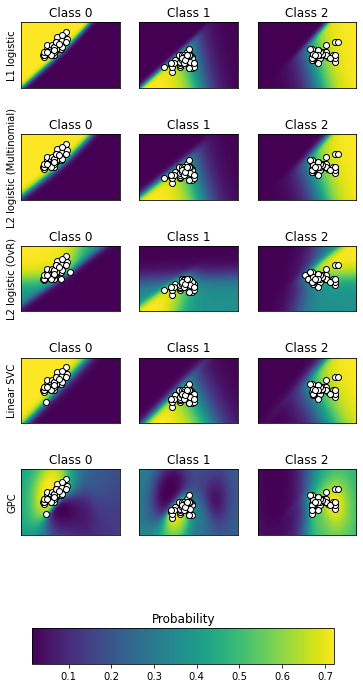

In [15]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn import datasets

for scorer in [
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
]:
    iris = datasets.load_iris()
    X = iris.data[:, 0:2]
    y = iris.target
    n_features = X.shape[1]

    C = 10
    kernel = 1.0 * RBF([1.0, 1.0])

    classifiers = {
        "L1 logistic": LogisticRegression(
            C=C, penalty="l1", solver="saga", multi_class="multinomial", max_iter=10000
        ),
        "L2 logistic (Multinomial)": LogisticRegression(
            C=C, penalty="l2", solver="saga", multi_class="multinomial", max_iter=10000
        ),
        "L2 logistic (OvR)": LogisticRegression(
            C=C, penalty="l2", solver="saga", multi_class="ovr", max_iter=10000
        ),
        "Linear SVC": SVC(kernel="linear", C=C, probability=True, random_state=__SEED__),
        "GPC": GaussianProcessClassifier(kernel),
    }

    n_classifiers = len(classifiers)

    plt.figure(figsize=(3 * 2, n_classifiers * 2))
    plt.subplots_adjust(bottom=0.2, top=0.95)

    xx = np.linspace(3, 9, 100)
    yy = np.linspace(1, 5, 100).T
    xx, yy = np.meshgrid(xx, yy)
    Xfull = np.c_[xx.ravel(), yy.ravel()]

    for index, (name, classifier) in enumerate(classifiers.items()):
        classifier.fit(X, y)

        y_pred = classifier.predict(X)
        if scorer in [precision_score, recall_score, f1_score]:
            score_val = scorer(y, y_pred, average="weighted")
        else:
            score_val = scorer(y, y_pred)
        print("Score (train) for %s: %0.1f%% " % (name, score_val * 100))

        # View probabilities:
        probas = classifier.predict_proba(Xfull)
        n_classes = np.unique(y_pred).size
        for k in range(n_classes):
            plt.subplot(n_classifiers, n_classes, index * n_classes + k + 1)
            plt.title("Class %d" % k)
            if k == 0:
                plt.ylabel(name)
            imshow_handle = plt.imshow(
                probas[:, k].reshape((100, 100)), extent=(3, 9, 1, 5), origin="lower"
            )
            plt.xticks(())
            plt.yticks(())
            idx = y_pred == k
            if idx.any():
                plt.scatter(X[idx, 0], X[idx, 1], marker="o", c="w", edgecolor="k")

    print('----' * 25)
    ax = plt.axes([0.15, 0.04, 0.7, 0.05])
    plt.title("Probability")
    plt.colorbar(imshow_handle, cax=ax, orientation="horizontal")

    plt.show()


## Regression Metrics

- $R^{2}$ (Coefficient of Determination)
- Mean Squared Error
- Mean Absolute Error
- Mean Squared Log Error

### $R^{2}$ (Coefficient of Determination)

Bounds: $R^{2} <= 1$

$R^{2}$ is the most common metric that we will encounter in machine learning and statistical analyses. A factor of it being an extremely simple metric to calculate and easy to understand (or is it?).

$R^{2}$ is defined as the proportion of the variance in the dependent variable that is predictable from the independent variable(s) [Wikipedia].

In other words, it is the `model-accounted variance / total variance`.
If it is 100%, it means the two variables are perfectly correlated with no variance in between.

$R^{2}$ assumes that the error is normally distributed and relatively small compared to the total variance. When your true function is unknown, it can become difficult to provide evidence that it is normally distributed across all input variables.

If you recall from above, the `model.score()` yielded a very high value (0.96). By default and cannot be changed, the score() method in scikit-learn returns the $R^{2}$. Still, we know that the model wasn't very good because we knew the underlying function. This is why it's important to understand your data and what metric best suits it.

If you want to calculate $R^{2}$:

In [16]:
from sklearn.metrics import r2_score

predictions = model.predict(x_test_cos.reshape(-1, 1))
score = r2_score(y_test_cos, predictions)
print(score)


0.9805356040502894


There are a few other statistical measures to evaluate regression models but they are not as commonly used as distance based metrics.

Here are some of the others:
- Mallow's Cp [https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fowlkes_mallows_score.html](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fowlkes_mallows_score.html)
- Akaike information criterion (AIC)
- Bayes Information criterion (BIC)
- Adjusted $R^{2}$

### Distance Based Regression Metrics

- MSE & RMSE
- MAE
- MSLE & RMSLE

All these are distance based metrics as in they calculate the distance between the predicted and the true value (i.e. how many units away did it predict from the true value?). A big bonus of these metrics (excluding MSE/MSLE) is that they all have the same units as the target variable unlike $R^{2}$.

### Mean Squared Error (MSE) / Root Mean Squared Error (RMSE)

Mean Squared Error takes the error of the prediction and true values, squares it, and then takes the average of the resulting vector. MSE is not normalized so we cannot use it anecdotally between different problems as high values for one problem may be small for another. For example, let's say the target variable for one problem is between the range of 10 - 20 and the target variable for another problem is between 10,000 - 20,000. The MSE will be significantly larger in the latter.

TLDR:
- Takes the average of the square of the difference between the true values and the predicted values.
- The effect of larger errors skew this metric significantly (i.e. outliers need to be removed / handled).
  - MSE is good if outliers should be exaggerated.
- RMSE is good for Gaussian distributions because it analogous to standard deviation.
- Bound: (0, infinity]

In [17]:
from sklearn.metrics import mean_squared_error
from math import sqrt

mse_score = mean_squared_error(y_test_cos, predictions)
rmse_score = sqrt(mean_squared_error(y_test_cos, predictions))

print(f"mse_score: {mse_score}")
print(f"rmse_score: {rmse_score}")


mse_score: 0.009086859803945089
rmse_score: 0.09532502191945769


### Mean Absolute Error

Mean Absolute Error takes the error of the prediction and true values, gets the absolute value, and takes the average (in that order). It is similar to MSE but it is robust against outliers (outliers are handled linearly).

TLDR:

- Average of the absolute value of the difference between the true values and the predicted values.
- Cannot indicate whether we are under or over predicting the target variable (i.e. does not indicate direciton of error).
- Handles outliers linearly so less of an issue (cases where outliers are less of an issue).
- Bound: (0, infinity]

N.B. Calculating MAE is computationally inefficient so most libraries (scikit-learn, tensorflow, pytorch, etc.) default to calculating MSE. This is because the MSE gradient function is easily differentiable unlike MAE's which is a complex linear system. If you're dealing with small datasets, this isn't an issue. However, when you're training on millions of points every day (Amazon collected hundreds of millions of points per day), this can become quite expensive.

In [18]:
from sklearn.metrics import mean_absolute_error

mae_score = mean_absolute_error(y_test_cos, predictions)
print(f"mae_score: {mae_score}")


mae_score: 0.07227393024314335


### Root Mean Squared Logarithmic Error (RMSLE)

Mean Squared Logarithmic Error takes the log of the true values and the predicted values, takes the difference, squares them, calculated the average of the vector, and then takes the root of the average. This is particularly useful when the target variable has a large range (e.g. 10 to 10,000) as it doesn't penalize the model for the variation across the samples.

TLDR:
- Useful for target variables that have an exponential or growing nature.
  - E.g. unconvential well decline curve: earlier values are much larger compared to latter where the decline curve flattens.
- It shows relative error (range is not an issue).
- Over-predicted values (predictions higher than the true values) are penalized less than under-predicted values (predictions lower than the true values).

In [19]:
from sklearn.metrics import mean_squared_log_error

msle_score = mean_squared_log_error(
    (y_test_cos + abs(np.min(y_test_cos))), (predictions + abs(np.min(predictions)))
)
print(f"msle_score: {msle_score}")


msle_score: 0.006451425079499329


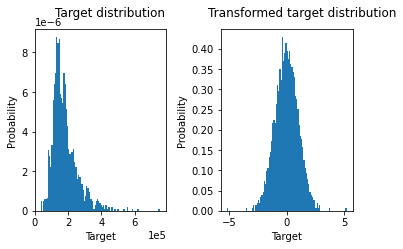

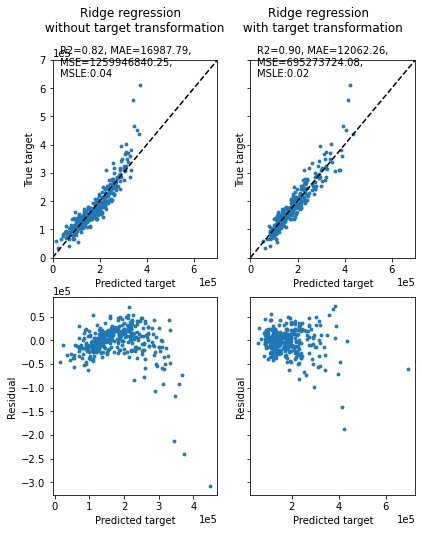

In [20]:
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import QuantileTransformer, quantile_transform
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import (
    median_absolute_error,
    r2_score,
    mean_squared_error,
    mean_squared_log_error,
)

density_param = {"density": True}

ames = fetch_openml(name="house_prices", as_frame=True)
X = ames.data.select_dtypes(np.number)
X = X.drop(columns=["LotFrontage", "GarageYrBlt", "MasVnrArea"])
y = ames.target
y_trans = quantile_transform(
    y.to_frame(), n_quantiles=900, output_distribution="normal", copy=True
).squeeze()

f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y, bins=100, **density_param)
ax0.set_ylabel("Probability")
ax0.set_xlabel("Target")
ax0.text(s="Target distribution", x=1.2e5, y=9.8e-6, fontsize=12)
ax0.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

ax1.hist(y_trans, bins=100, **density_param)
ax1.set_ylabel("Probability")
ax1.set_xlabel("Target")
ax1.text(s="Transformed target distribution", x=-6.8, y=0.479, fontsize=12)

f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=__SEED__)

f, (ax0, ax1) = plt.subplots(2, 2, sharey="row", figsize=(6.5, 8))

regr = RidgeCV()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

ax0[0].scatter(y_pred, y_test, s=8)
ax0[0].plot([0, 7e5], [0, 7e5], "--k")
ax0[0].set_ylabel("True target")
ax0[0].set_xlabel("Predicted target")
ax0[0].text(
    s="Ridge regression \n without target transformation",
    x=-5e4,
    y=8e5,
    fontsize=12,
    multialignment="center",
)
ax0[0].text(
    3e4,
    64e4,
    "R2=%.2f, MAE=%.2f, \nMSE=%.2f, \nMSLE:%.2f"
    % (
        r2_score(y_test, y_pred),
        median_absolute_error(y_test, y_pred),
        mean_squared_error(y_test, y_pred),
        mean_squared_log_error(abs(y_test), abs(y_pred)),
    ),
)
ax0[0].set_xlim([0, 7e5])
ax0[0].set_ylim([0, 7e5])
ax0[0].ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

ax1[0].scatter(y_pred, (y_pred - y_test), s=8)
ax1[0].set_ylabel("Residual")
ax1[0].set_xlabel("Predicted target")
ax1[0].ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

regr_trans = TransformedTargetRegressor(
    regressor=RidgeCV(),
    transformer=QuantileTransformer(n_quantiles=900, output_distribution="normal"),
)
regr_trans.fit(X_train, y_train)
y_pred = regr_trans.predict(X_test)

ax0[1].scatter(y_pred, y_test, s=8)
ax0[1].plot([0, 7e5], [0, 7e5], "--k")
ax0[1].set_ylabel("True target")
ax0[1].set_xlabel("Predicted target")
ax0[1].text(
    s="Ridge regression \n with target transformation",
    x=-5e4,
    y=8e5,
    fontsize=12,
    multialignment="center",
)
ax0[1].text(
    3e4,
    64e4,
    "R2=%.2f, MAE=%.2f, \nMSE=%.2f, \nMSLE:%.2f"
    % (
        r2_score(y_test, y_pred),
        median_absolute_error(y_test, y_pred),
        mean_squared_error(y_test, y_pred),
        mean_squared_log_error(abs(y_test), abs(y_pred)),
    ),
)
ax0[1].set_xlim([0, 7e5])
ax0[1].set_ylim([0, 7e5])
ax0[1].ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

ax1[1].scatter(y_pred, (y_pred - y_test), s=8)
ax1[1].set_ylabel("Residual")
ax1[1].set_xlabel("Predicted target")
ax1[1].ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

plt.show()


# Model Interpretation

It is extremely important to be able to interpret your models in a layman manner. Very few companies or teams will take action from what a model outputs if they can't understand what it's doing. The real value in machine learning is understanding how these models are reaching their conclusion so that we can improve our processes in a transparent manner.

Libraries to Explore:
- [https://github.com/marcotcr/lime](https://github.com/marcotcr/lime)
- [https://github.com/TeamHG-Memex/eli5](https://github.com/TeamHG-Memex/eli5)
- [https://github.com/slundberg/shap](https://github.com/slundberg/shap)
- [https://github.com/aerdem4/lofo-importance](https://github.com/aerdem4/lofo-importance)

A common method of being able to interpret your models is called SHAP or SHapley Additive exPlanations. The Shapley value is a solution concept used in game theory that involves fairly distributing both gains and costs to several actors working in coalition. Game theory is when two or more players or factors are involved in a strategy to achieve a desired outcome or payoff. The Shapley value applies primarily in situations when the contributions of each actor are unequal, but each player works in cooperation with each other to obtain the gain or payoff.

You can read more about it [here](https://www.investopedia.com/terms/s/shapley-value.asp#:~:text=In%20game%20theory%2C%20the%20Shapley,other%20to%20obtain%20the%20payoff).

Here are a couple examples:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


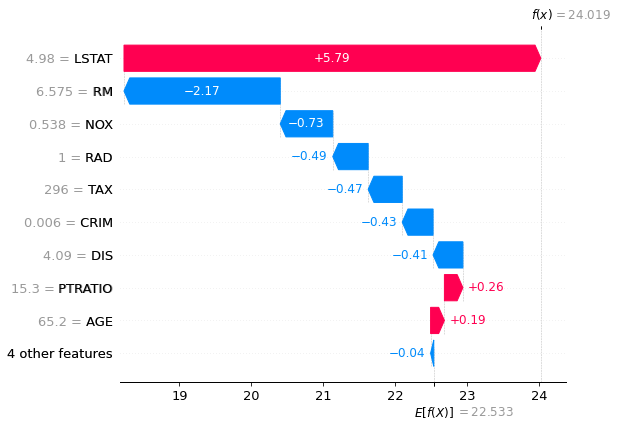

In [21]:
import xgboost
import shap

X, y = shap.datasets.boston()
model = xgboost.XGBRegressor().fit(X, y)
explainer = shap.Explainer(model)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[0])


The above shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

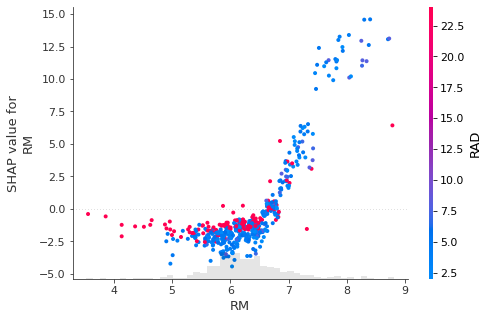

In [22]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"RM"], color=shap_values)


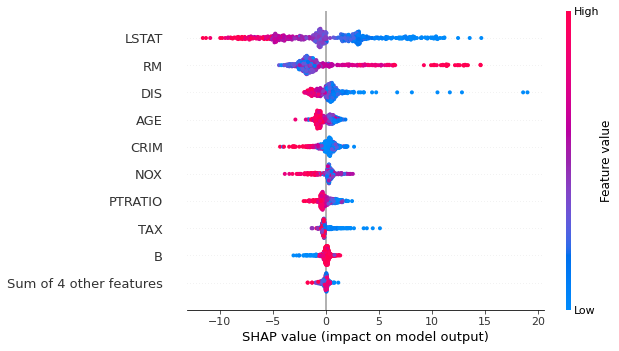

In [23]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)


And my personal favorite from their examples: 
[https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/gradient_imagenet_plot.png](https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/gradient_imagenet_plot.png)


In [24]:
geomech_df = pd.read_csv("../data/merged_tests_w_residual.csv")

validation = geomech_df.sample(frac=0.1)
X_val = validation[
    [
        "confining_pressure",
        "bulk_density",
        "deviatoric_stress",
        "pred_vp",
        "pred_vs",
        # "orientation",
    ]
]
y_val = validation.youngs_modulus

ml_df = geomech_df.drop(validation.index, errors="ignore")
X_ml = ml_df[
    [
        "confining_pressure",
        "bulk_density",
        "deviatoric_stress",
        "pred_vp",
        "pred_vs",
        # "orientation",
    ]
]
y_ml = ml_df.youngs_modulus
X_train, X_test, y_train, y_test = train_test_split(
    X_ml, y_ml, test_size=0.2, random_state=__SEED__
)


In [25]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

numeric_features = (
    ml_df[
        [
            "confining_pressure",
            "bulk_density",
            "deviatoric_stress",
            "pred_vp",
            "pred_vs",
            # "orientation",
        ]
    ]
    .select_dtypes(include=["int64", "float64"])
    .columns
)
categorical_features = (
    ml_df[
        [
            "confining_pressure",
            "bulk_density",
            "deviatoric_stress",
            "pred_vp",
            "pred_vs",
            # "orientation",
        ]
    ]
    .select_dtypes(include=["object"])
    .columns
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

rf_pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", RandomForestRegressor())]
)

param_grid = {
    "regressor__n_estimators": [200, 300, 400, 500, 1000],
    "regressor__max_depth": [10, 20, 30, 50, 100, 200, 300, 400, 500, 1000],
}

scoring = {
    "MAE": make_scorer(mean_absolute_error),
    "RMSE": make_scorer(mean_squared_error),
    "RMSLE": make_scorer(mean_squared_log_error),
    "R2": make_scorer(r2_score),
}


Function: MAE ::: Regressor Parameters: {'regressor__max_depth': 50, 'regressor__n_estimators': 300},
 Score: 3.74097893462026
----------------------------------------
Function: RMSE ::: Regressor Parameters: {'regressor__max_depth': 500, 'regressor__n_estimators': 400},
 Score: 24.07991598951469
----------------------------------------
Function: RMSLE ::: Regressor Parameters: {'regressor__max_depth': 400, 'regressor__n_estimators': 300},
 Score: 0.029974470776156024
----------------------------------------


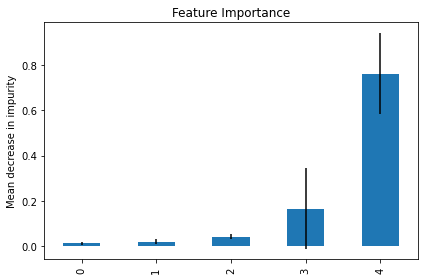

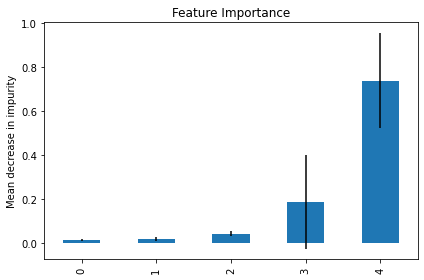

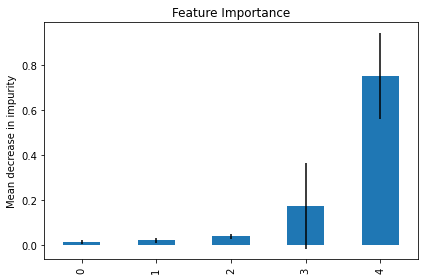

In [26]:
for scoring_function in ["MAE", "RMSE", "RMSLE"]:
    CV = GridSearchCV(rf_pipe, param_grid, scoring=scoring, refit=scoring_function, n_jobs=-1)

    mae_results = CV.fit(
        ml_df[
            [
                "confining_pressure",
                "bulk_density",
                "deviatoric_stress",
                "pred_vp",
                "pred_vs",
                # "orientation",
            ]
        ],
        ml_df.youngs_modulus,
    )
    print(f"Function: {scoring_function} ::: Regressor Parameters: {CV.best_params_},\n Score: {CV.best_score_}")
    print("----" * 10)

    mae_tuned = CV.best_estimator_["regressor"]
    importances = mae_tuned.feature_importances_
    std = np.std([tree.feature_importances_ for tree in mae_tuned.estimators_], axis=0)
    forest_importances = pd.Series(importances)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature Importance")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()


In [27]:
import shap

shap.initjs()

feature_names = [
    "confining_pressure",
    "bulk_density",
    "deviatoric_stress",
    "pred_vp",
    "pred_vs",
    # "orientation",
]


def rf_predict(data_asarray):
    data_asframe = pd.DataFrame(data_asarray, columns=feature_names)
    return CV.predict(data_asframe)


shap_kernel_explainer = shap.KernelExplainer(rf_predict, X_train)
shap_values_single = shap_kernel_explainer.shap_values(X_test.iloc[[1]])
shap.force_plot(
    shap_kernel_explainer.expected_value, shap_values_single, X_test.iloc[[1]]
)


Using 219 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

In [28]:
shap.force_plot(shap_kernel_explainer.expected_value, shap_kernel_explainer.shap_values(X_test), X_test)

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

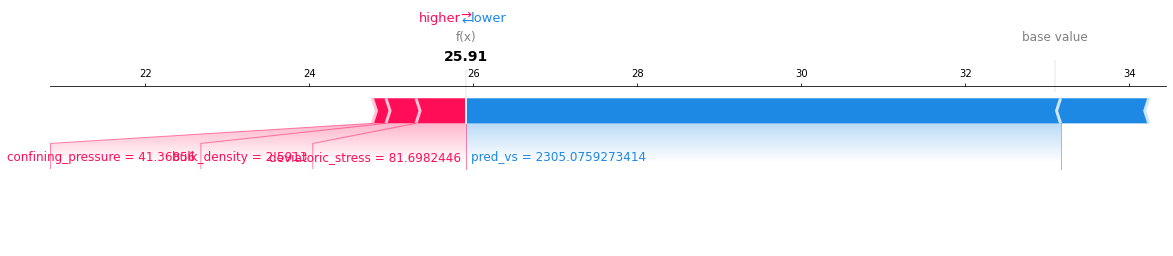

  0%|          | 0/1 [00:00<?, ?it/s]

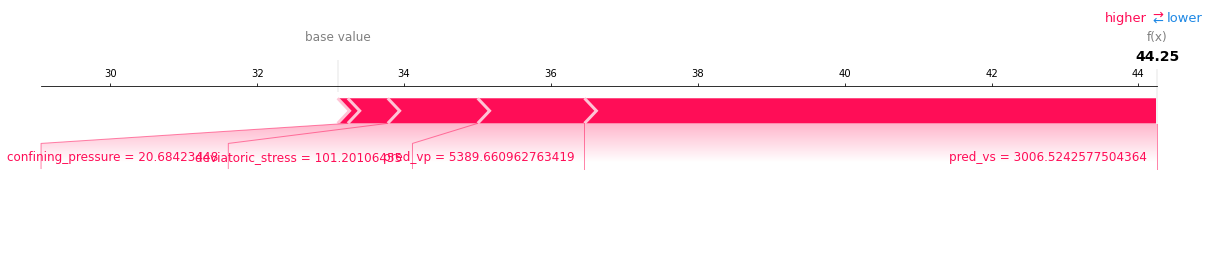

  0%|          | 0/1 [00:00<?, ?it/s]

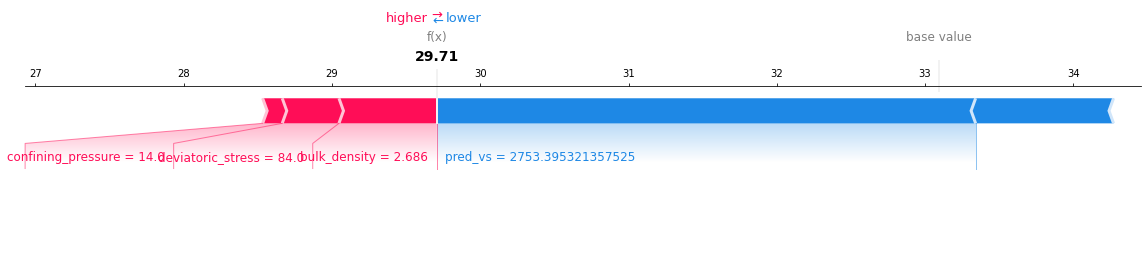

  0%|          | 0/1 [00:00<?, ?it/s]

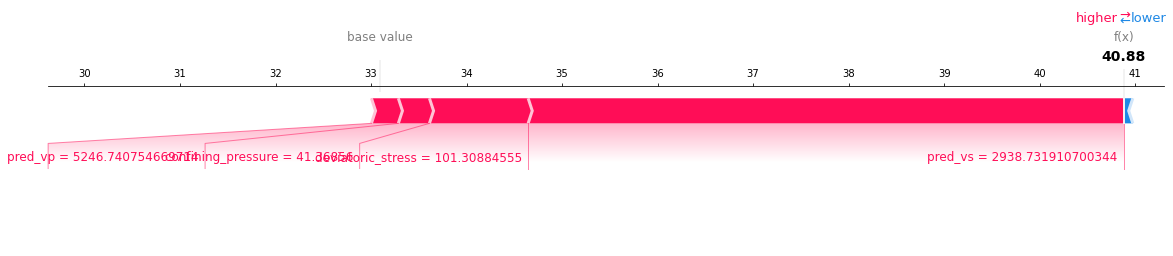

  0%|          | 0/1 [00:00<?, ?it/s]

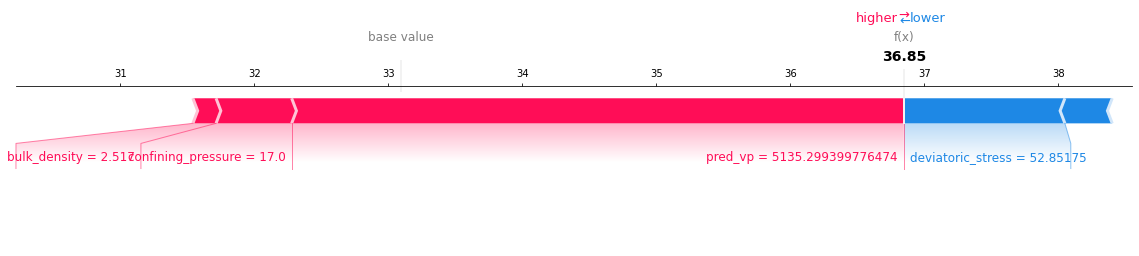

  0%|          | 0/1 [00:00<?, ?it/s]

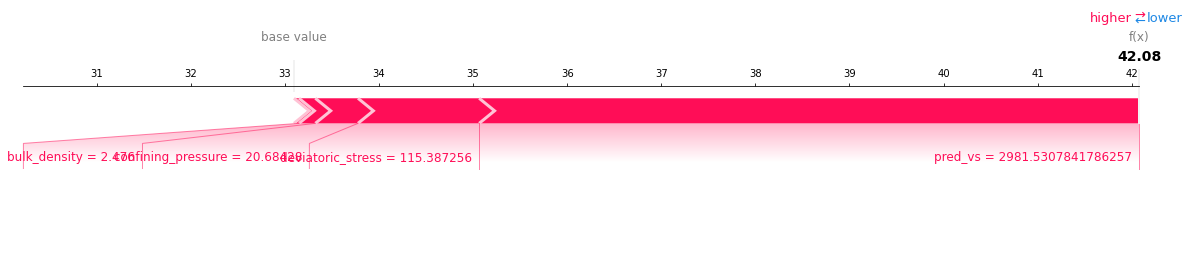

  0%|          | 0/1 [00:00<?, ?it/s]

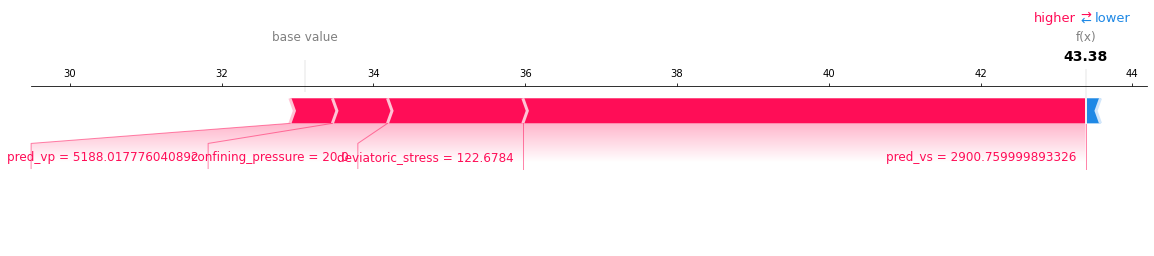

  0%|          | 0/1 [00:00<?, ?it/s]

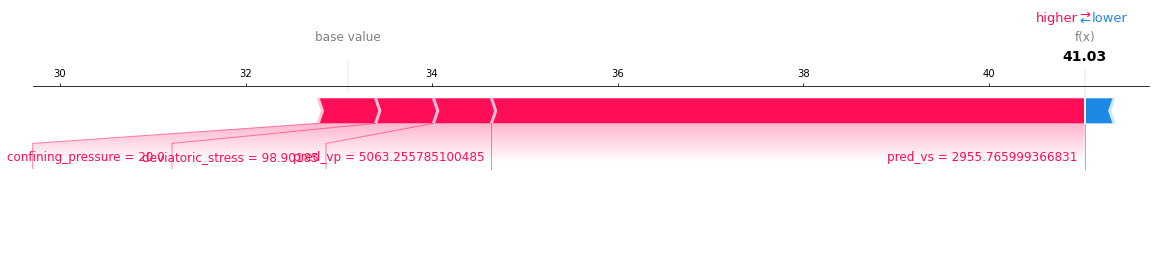

  0%|          | 0/1 [00:00<?, ?it/s]

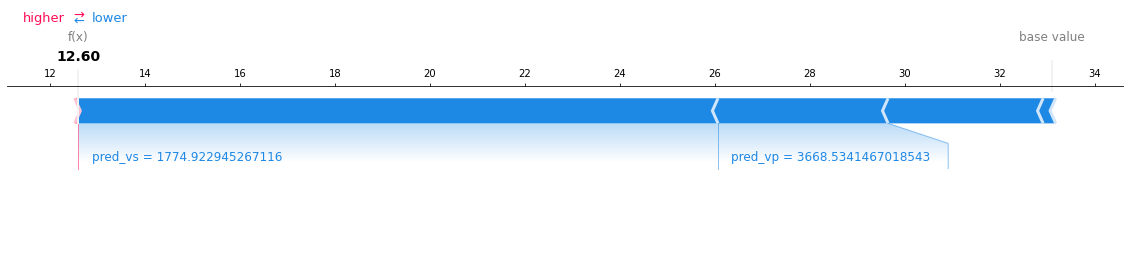

  0%|          | 0/1 [00:00<?, ?it/s]

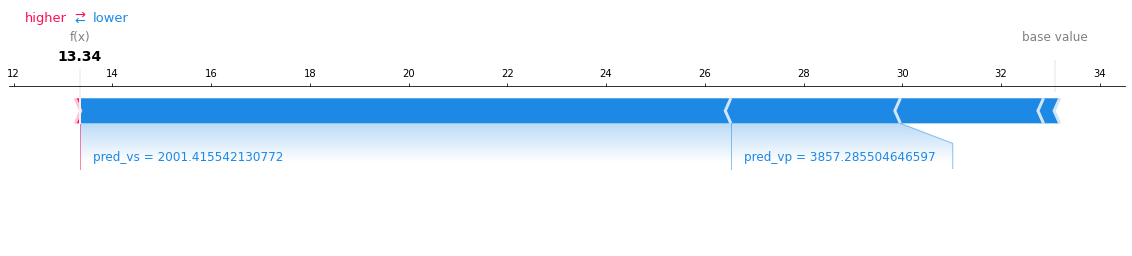

  0%|          | 0/1 [00:00<?, ?it/s]

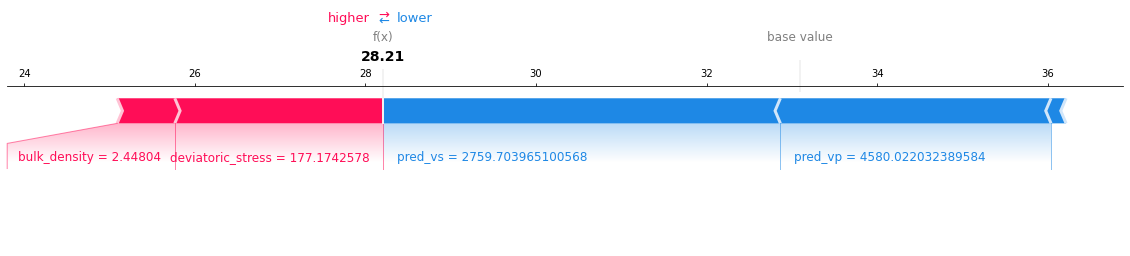

  0%|          | 0/1 [00:00<?, ?it/s]

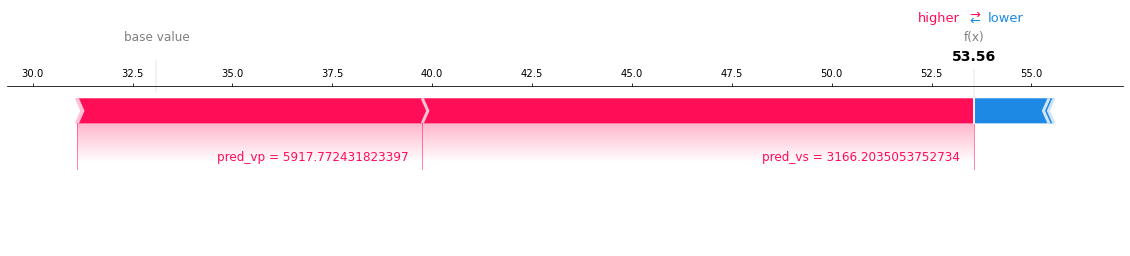

  0%|          | 0/1 [00:00<?, ?it/s]

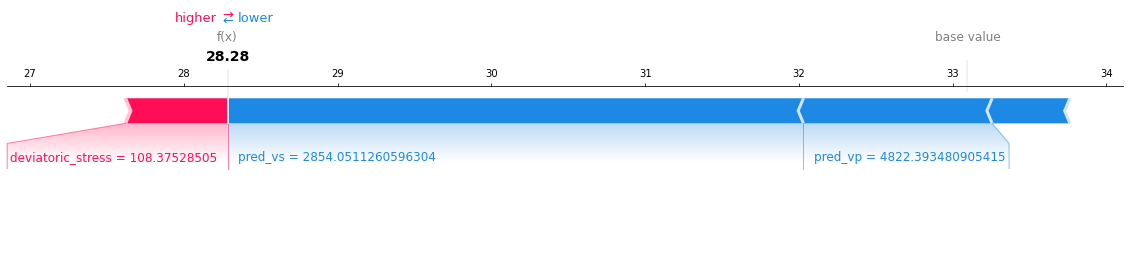

  0%|          | 0/1 [00:00<?, ?it/s]

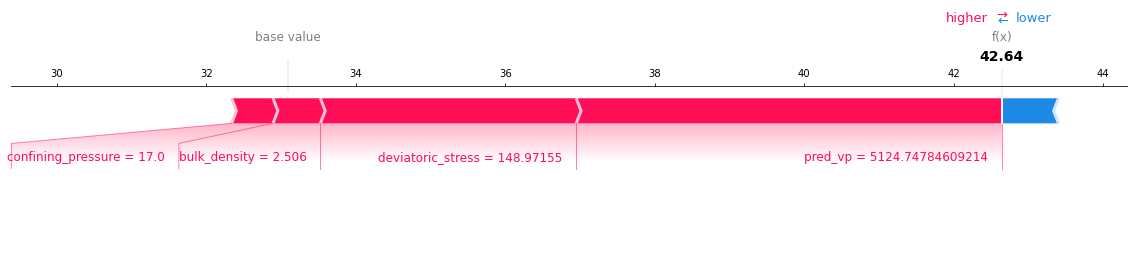

  0%|          | 0/1 [00:00<?, ?it/s]

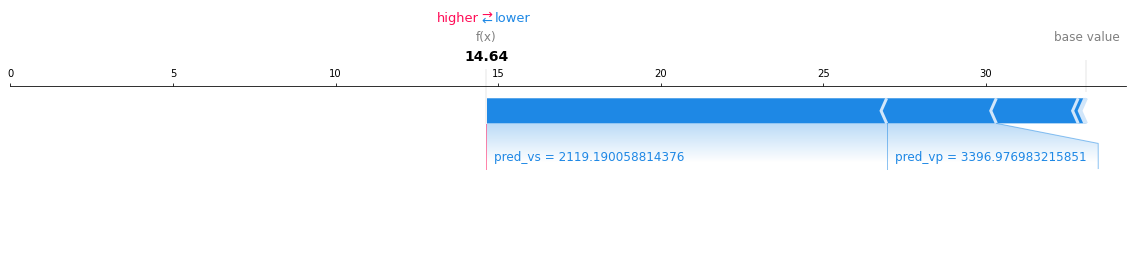

  0%|          | 0/1 [00:00<?, ?it/s]

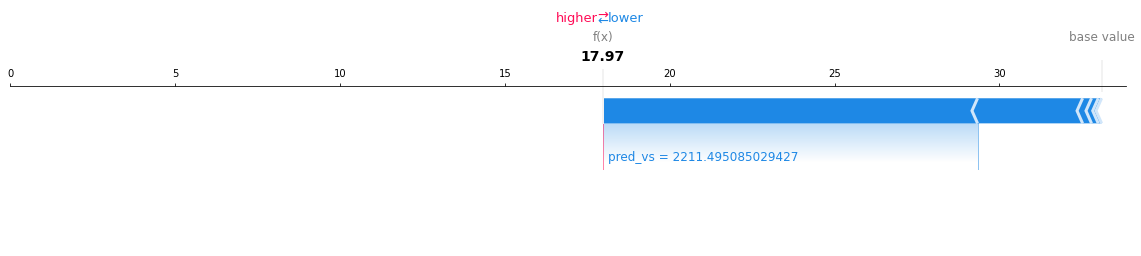

  0%|          | 0/1 [00:00<?, ?it/s]

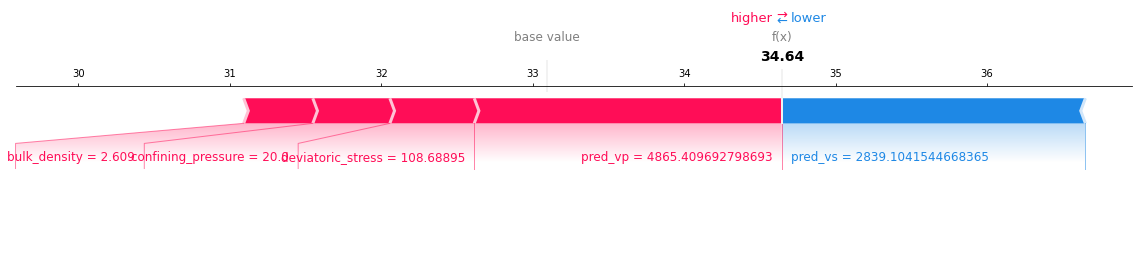

  0%|          | 0/1 [00:00<?, ?it/s]

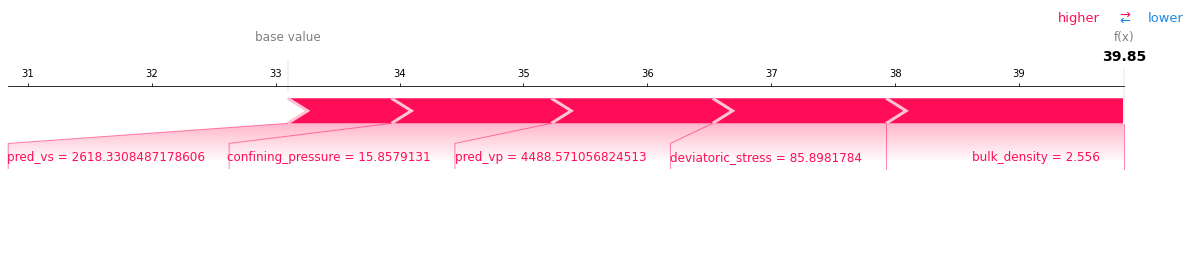

  0%|          | 0/1 [00:00<?, ?it/s]

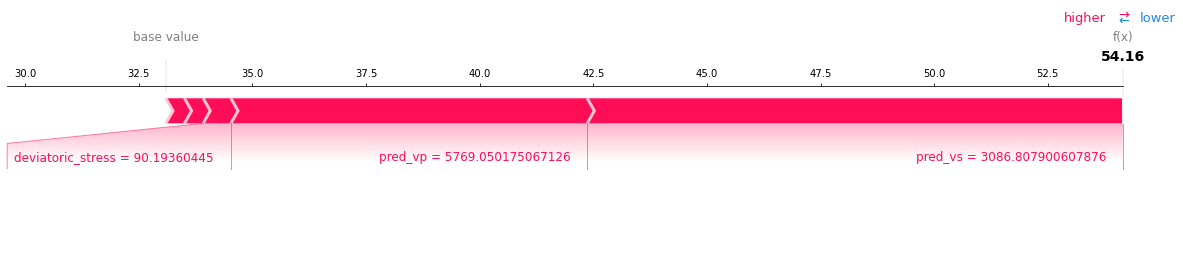

  0%|          | 0/1 [00:00<?, ?it/s]

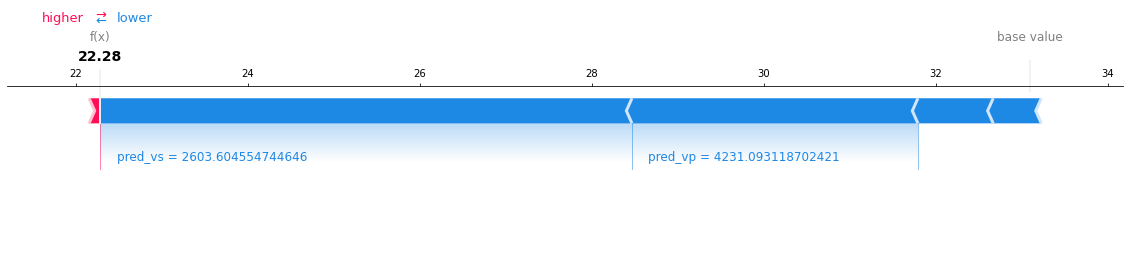

  0%|          | 0/1 [00:00<?, ?it/s]

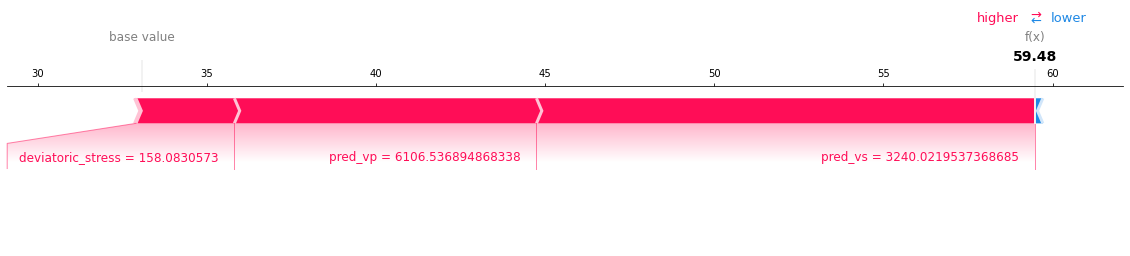

  0%|          | 0/1 [00:00<?, ?it/s]

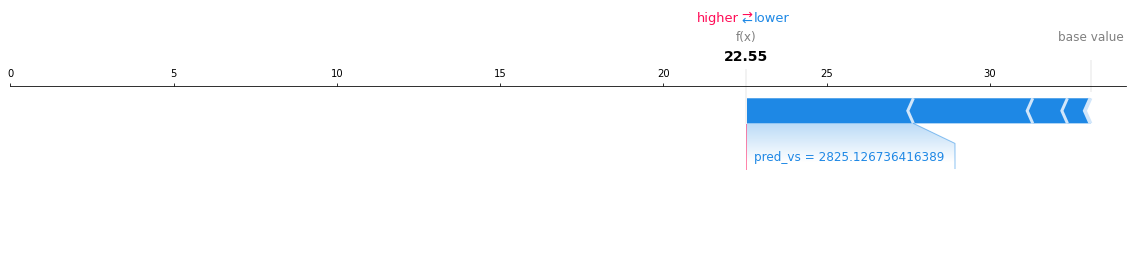

  0%|          | 0/1 [00:00<?, ?it/s]

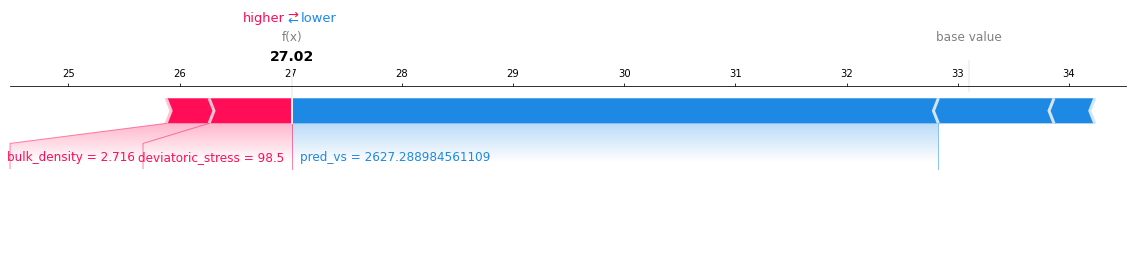

  0%|          | 0/1 [00:00<?, ?it/s]

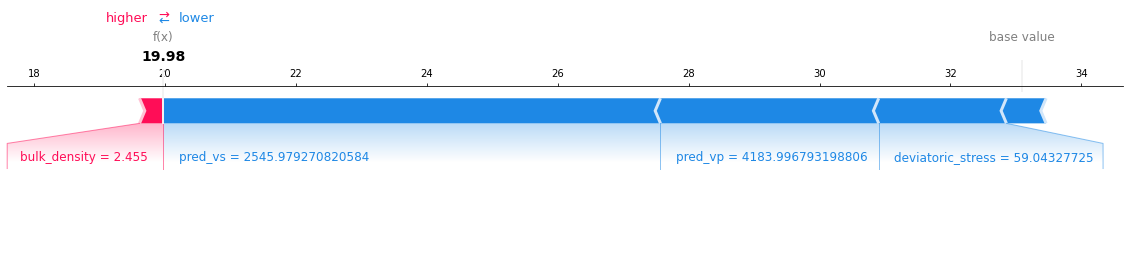

  0%|          | 0/1 [00:00<?, ?it/s]

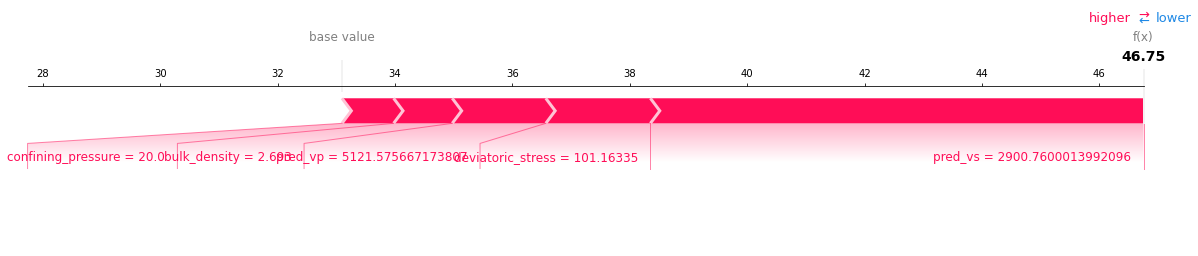

  0%|          | 0/1 [00:00<?, ?it/s]

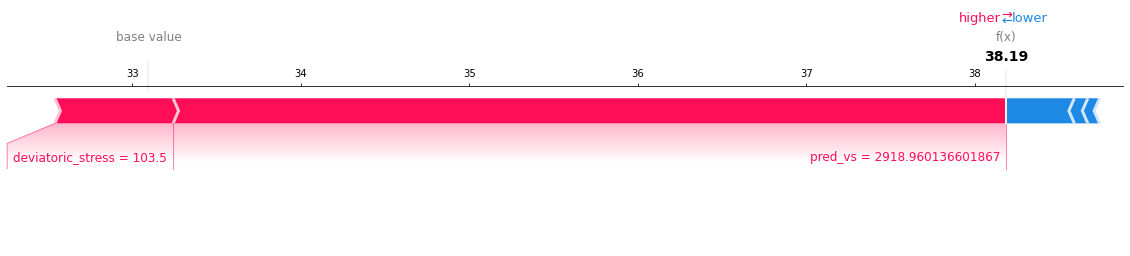

  0%|          | 0/1 [00:00<?, ?it/s]

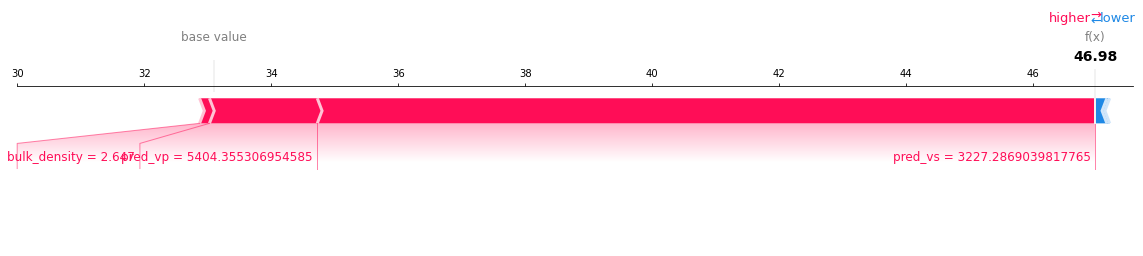

  0%|          | 0/1 [00:00<?, ?it/s]

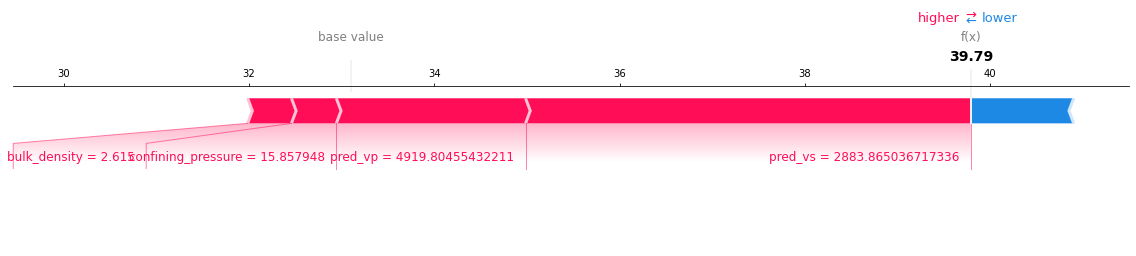

  0%|          | 0/1 [00:00<?, ?it/s]

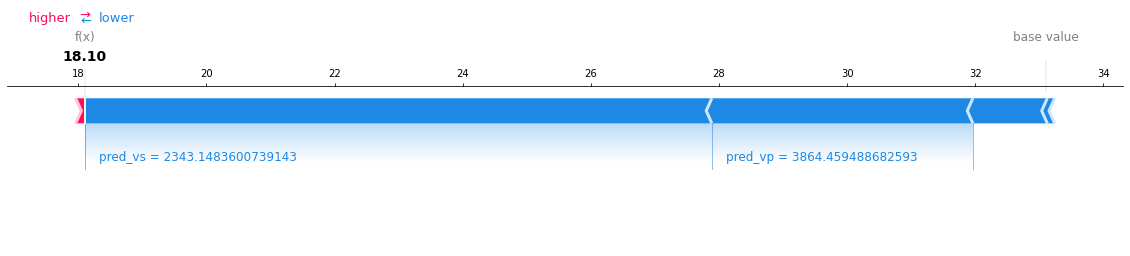

  0%|          | 0/1 [00:00<?, ?it/s]

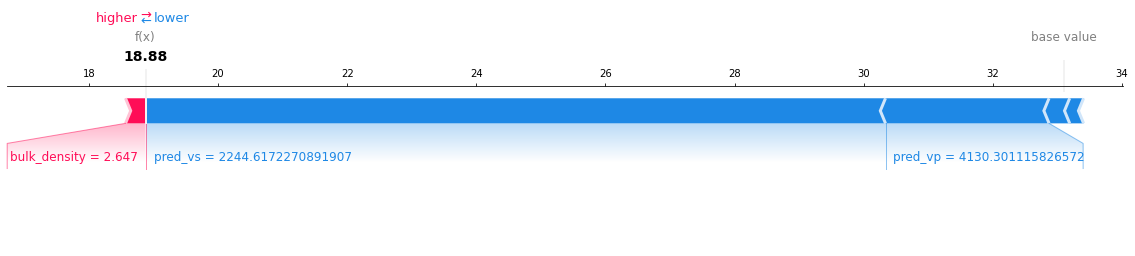

  0%|          | 0/1 [00:00<?, ?it/s]

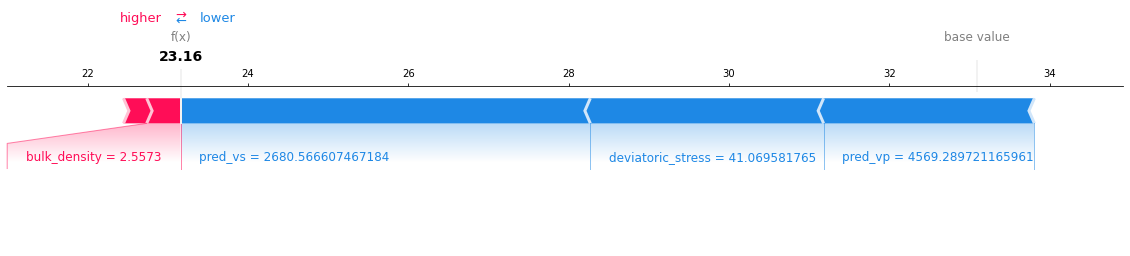

  0%|          | 0/1 [00:00<?, ?it/s]

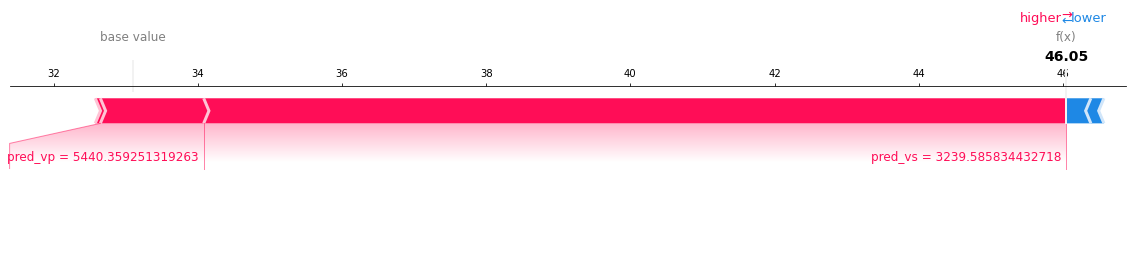

  0%|          | 0/1 [00:00<?, ?it/s]

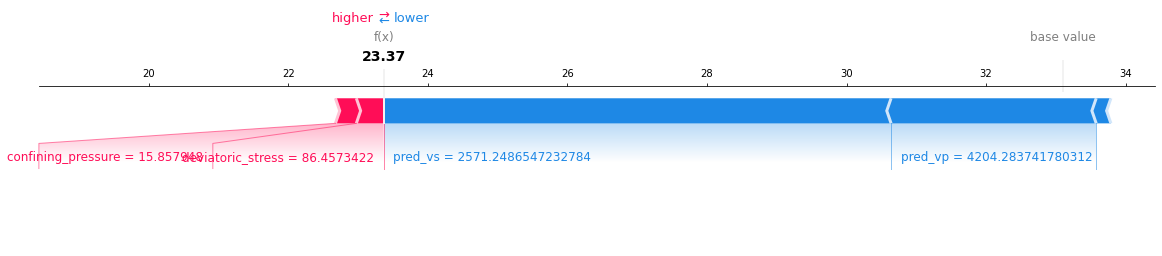

  0%|          | 0/1 [00:00<?, ?it/s]

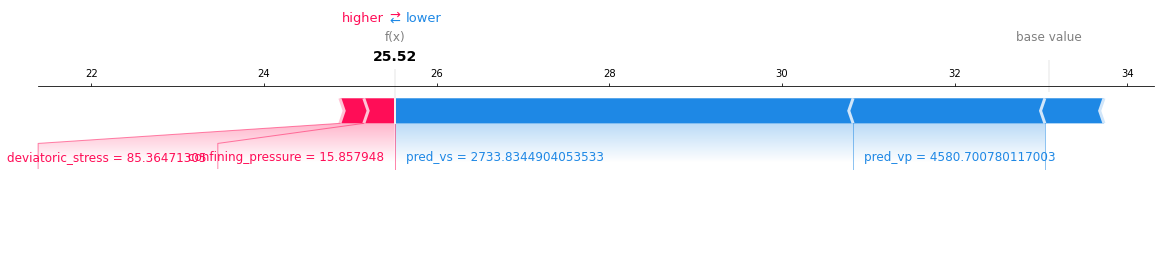

  0%|          | 0/1 [00:00<?, ?it/s]

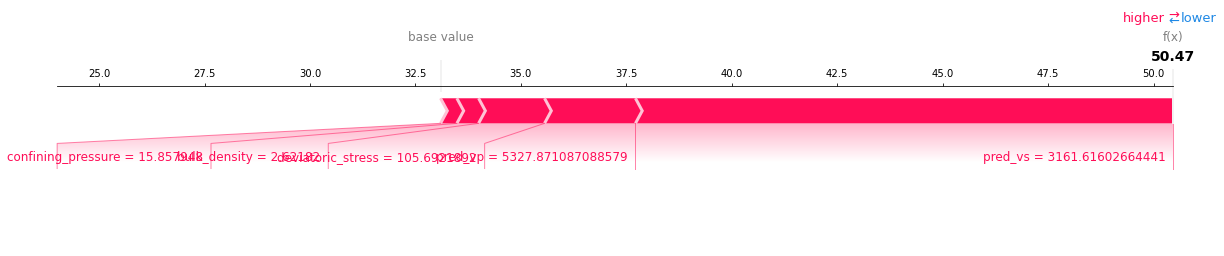

  0%|          | 0/1 [00:00<?, ?it/s]

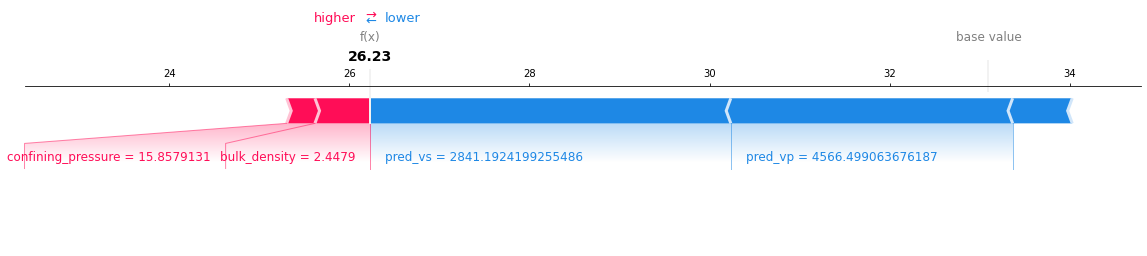

  0%|          | 0/1 [00:00<?, ?it/s]

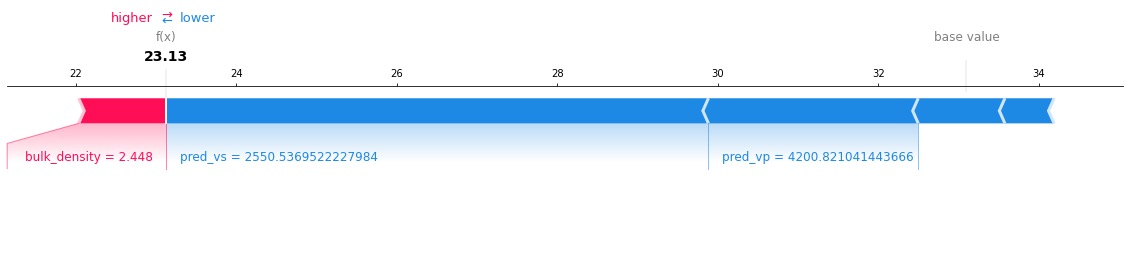

  0%|          | 0/1 [00:00<?, ?it/s]

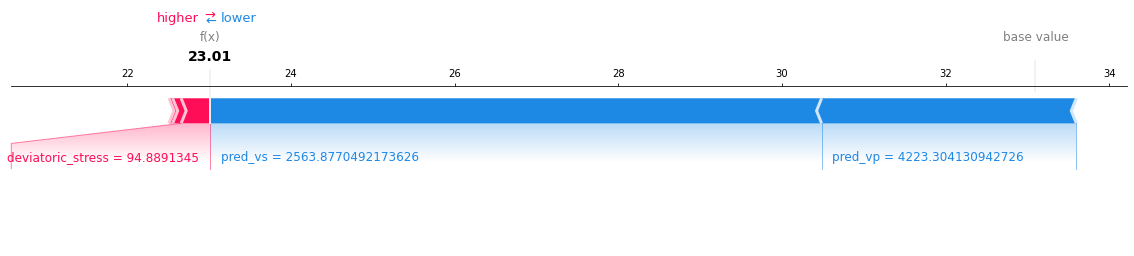

  0%|          | 0/1 [00:00<?, ?it/s]

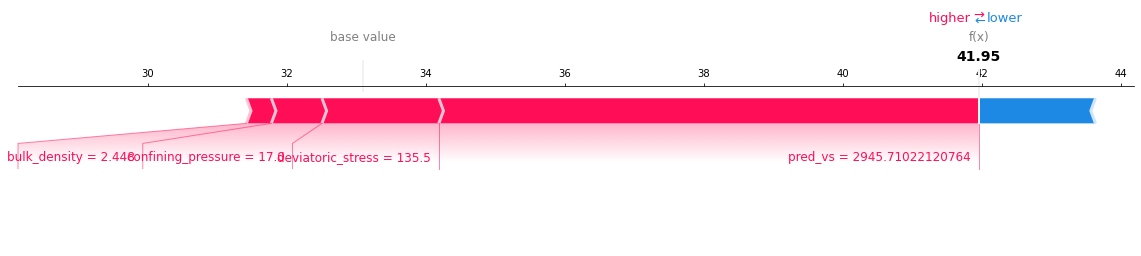

  0%|          | 0/1 [00:00<?, ?it/s]

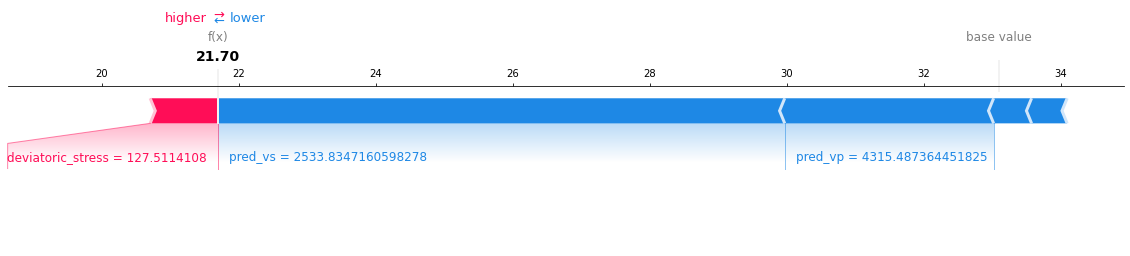

  0%|          | 0/1 [00:00<?, ?it/s]

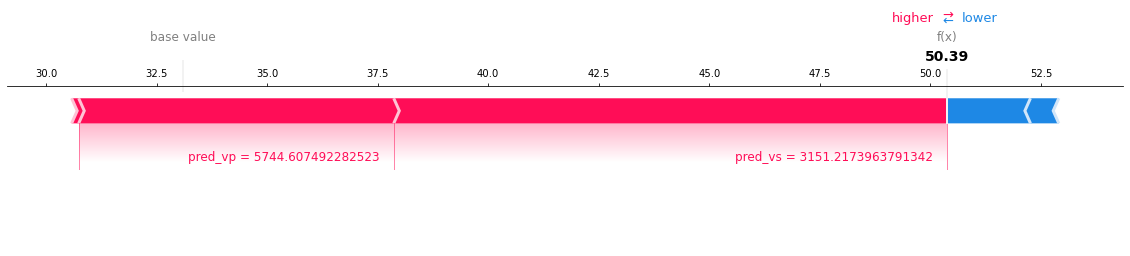

  0%|          | 0/1 [00:00<?, ?it/s]

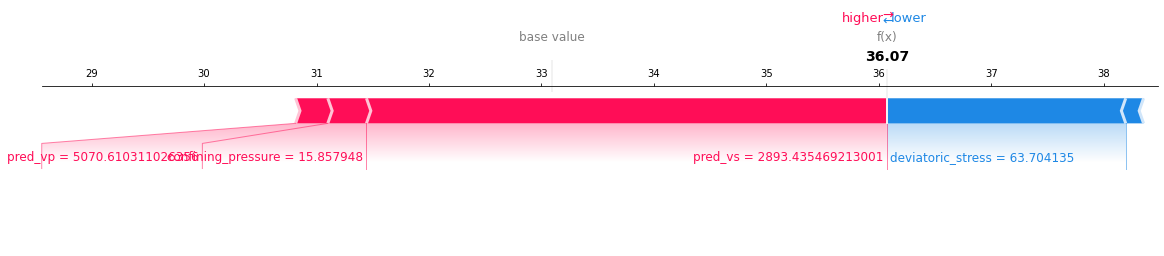

  0%|          | 0/1 [00:00<?, ?it/s]

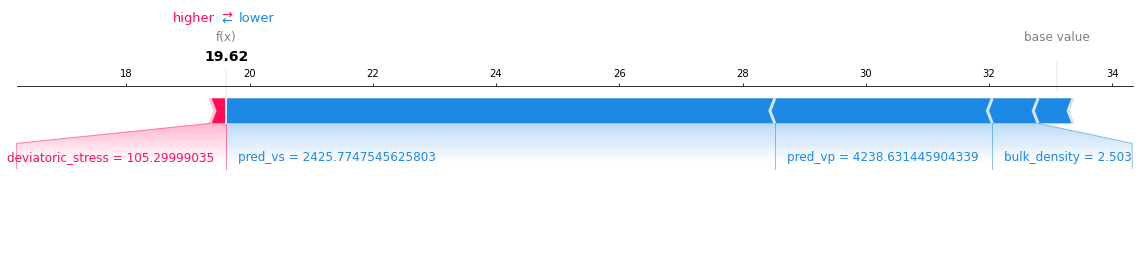

  0%|          | 0/1 [00:00<?, ?it/s]

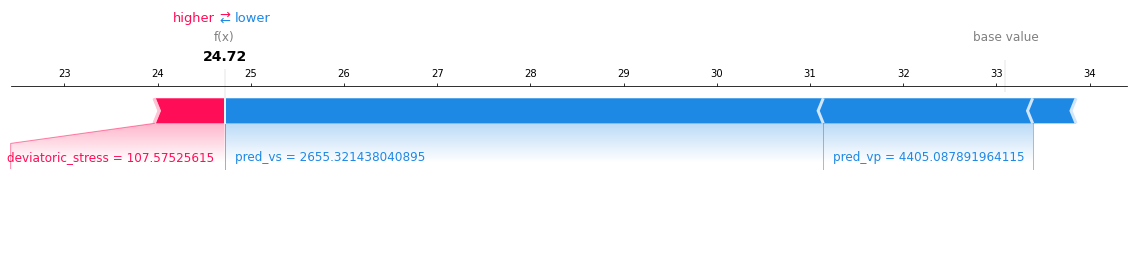

  0%|          | 0/1 [00:00<?, ?it/s]

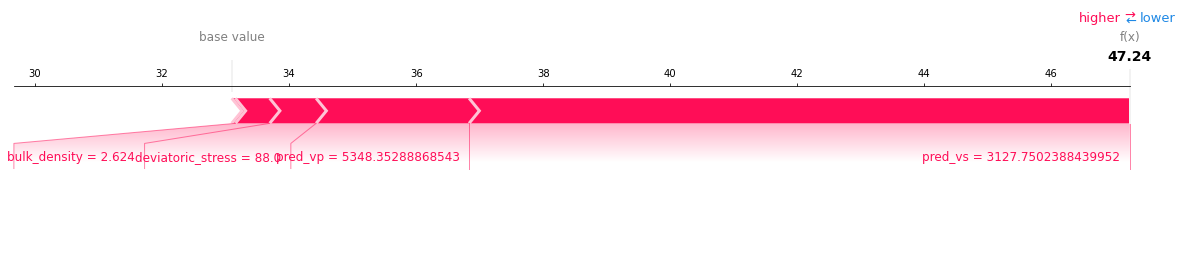

  0%|          | 0/1 [00:00<?, ?it/s]

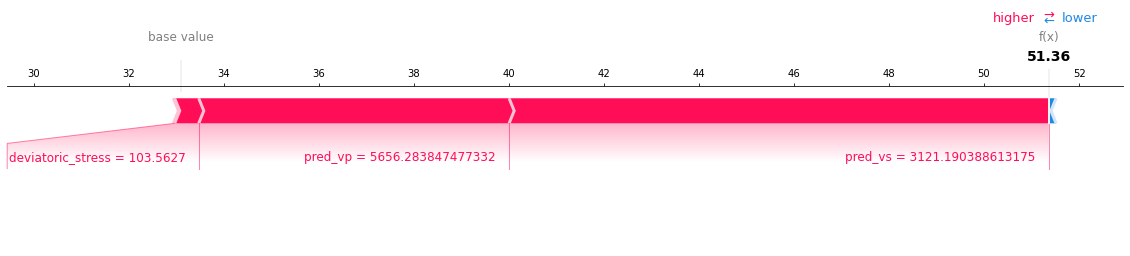

  0%|          | 0/1 [00:00<?, ?it/s]

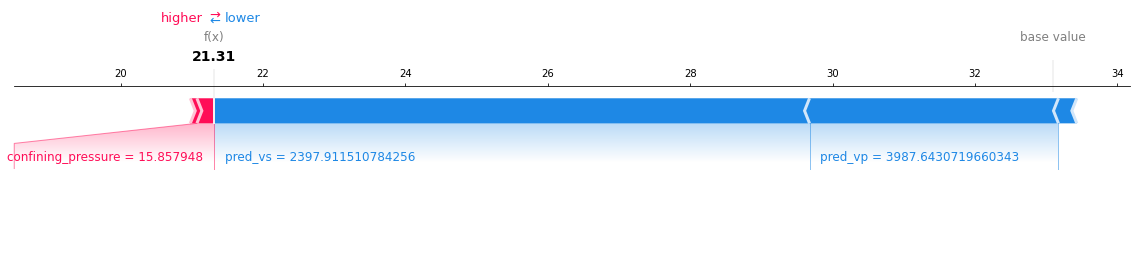

  0%|          | 0/1 [00:00<?, ?it/s]

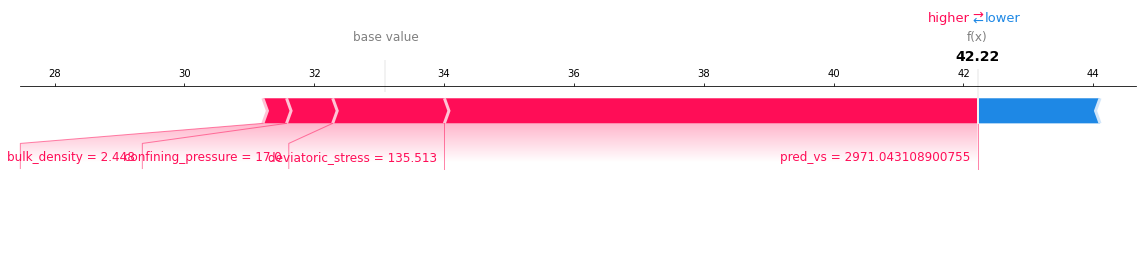

  0%|          | 0/1 [00:00<?, ?it/s]

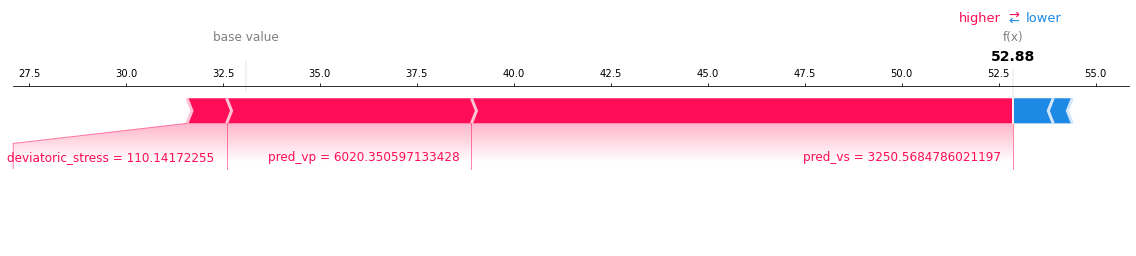

  0%|          | 0/1 [00:00<?, ?it/s]

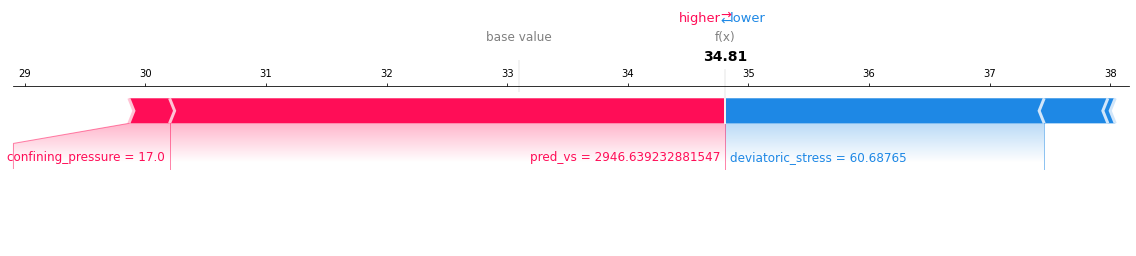

  0%|          | 0/1 [00:00<?, ?it/s]

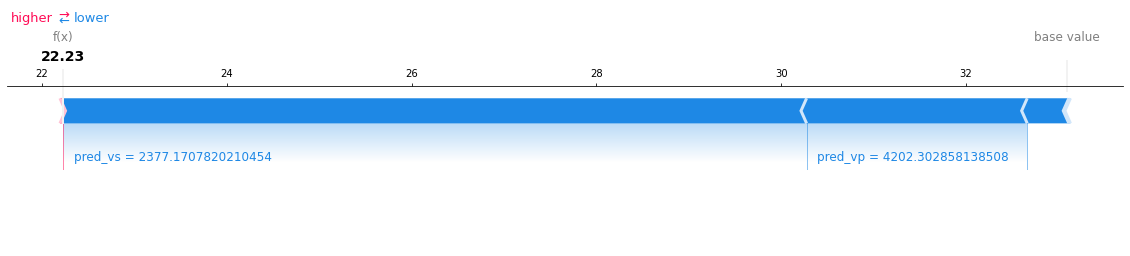

  0%|          | 0/1 [00:00<?, ?it/s]

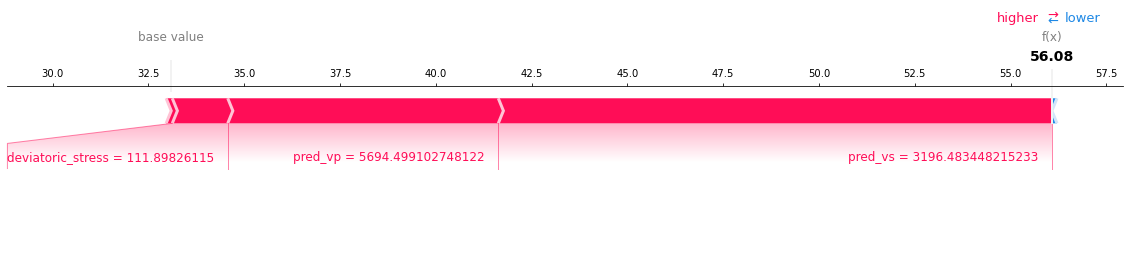

  0%|          | 0/1 [00:00<?, ?it/s]

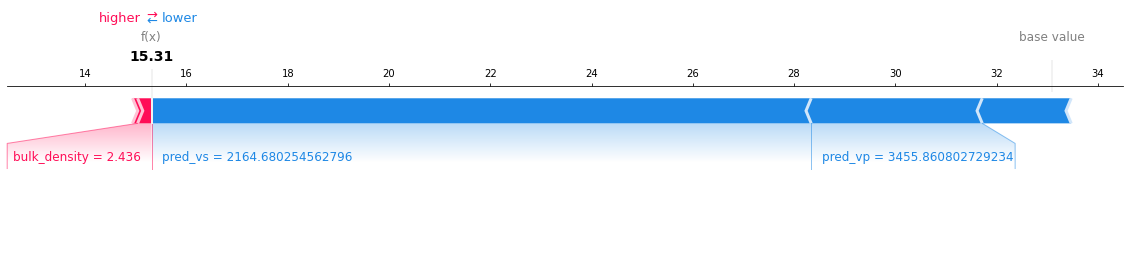

  0%|          | 0/1 [00:00<?, ?it/s]

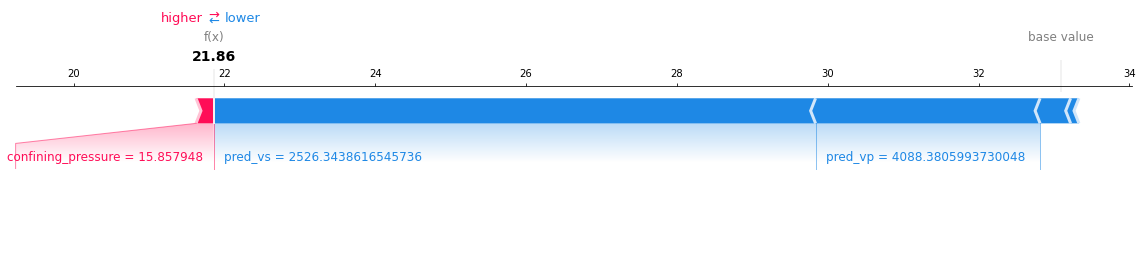

  0%|          | 0/1 [00:00<?, ?it/s]

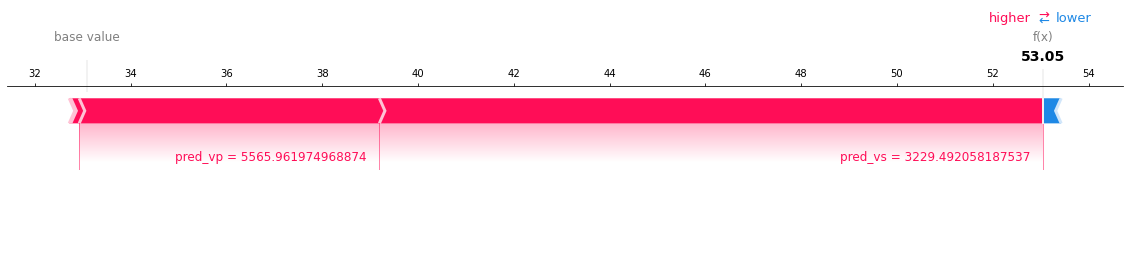

In [29]:
for i in range(X_test.shape[0]):
    # shap_values_single = shap_kernel_explainer.shap_values(X_test.iloc[[i]])
    shap.force_plot(
        shap_kernel_explainer.expected_value,
        shap_kernel_explainer.shap_values(X_test.iloc[[i]]),
        X_test.iloc[[i]],
        matplotlib=True,
    )


# Thank you and good luck in the datathon!